# Persistence Landscapes and Machine Learning
---

This notebook gives usage examples for the persistence landscape functionality in `persim` and how they connect with other tools from `scikit-learn`. We will construct persistence landscapes for two different datasets (a sphere and a torus), plot them in comparison with each other, and use statistical learning tools to classify the two types of landscapes. 


**THIS IS A WORK IN PROGRESS, PLEASE ADD TO AND REVISE THIS!**

## Section 1: Example Plots for Torus vs Sphere

In this section, we plot persistence diagrams and persistence landscapes for a torus and a sphere to give a heuristic example before a larger-scale classification problem.

In [1]:
# imports

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from ripser import Rips
from tadasets import torus, sphere
import persim

from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [2]:
data_torus = torus(n=100, c=2, a=2, ambient=10, noise=0.2)
data_sphere = sphere(n=100, r=2, ambient=10, noise=0.2)

In [3]:
rips = Rips(maxdim = 2)

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [4]:
dgms_torus = rips.fit_transform(data_torus)
dgms_sphere = rips.fit_transform(data_sphere)

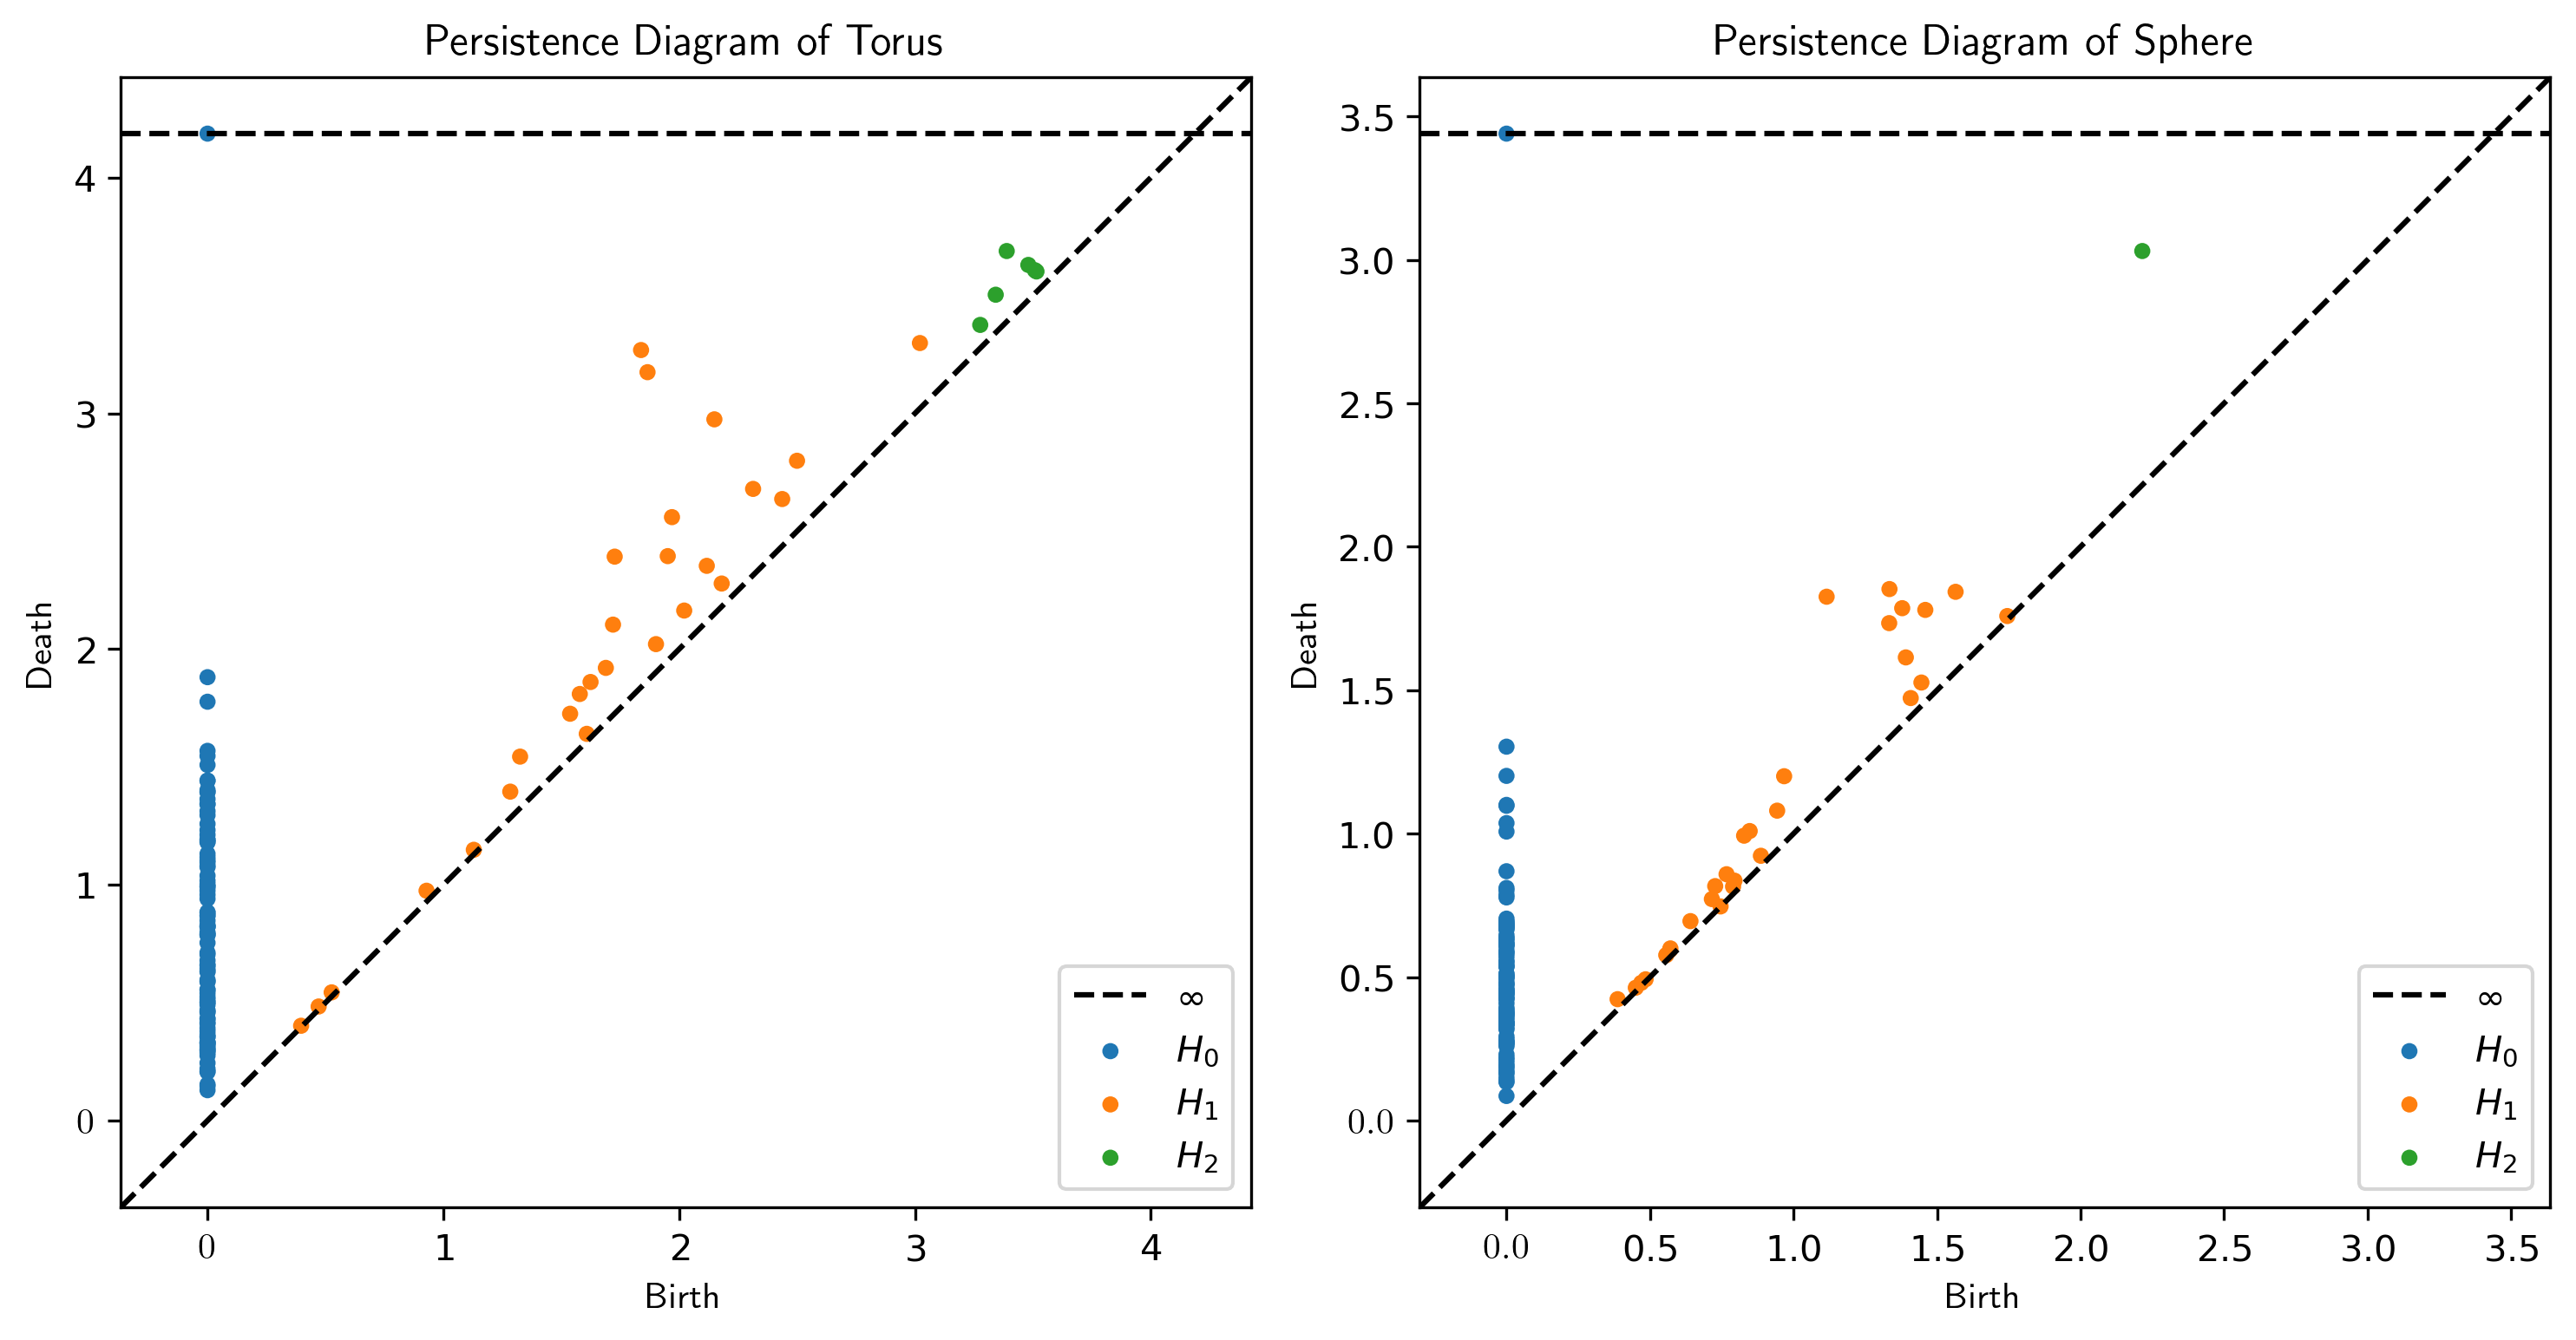

In [5]:
# Visualize the data
fig, axs = plt.subplots(1, 2, dpi=300)
fig.set_size_inches(10, 5)

persim.plot_diagrams(dgms_torus, title="Persistence Diagram of Torus", ax=axs[0])

persim.plot_diagrams(dgms_sphere, title="Persistence Diagram of Sphere", ax=axs[1])

fig.tight_layout()

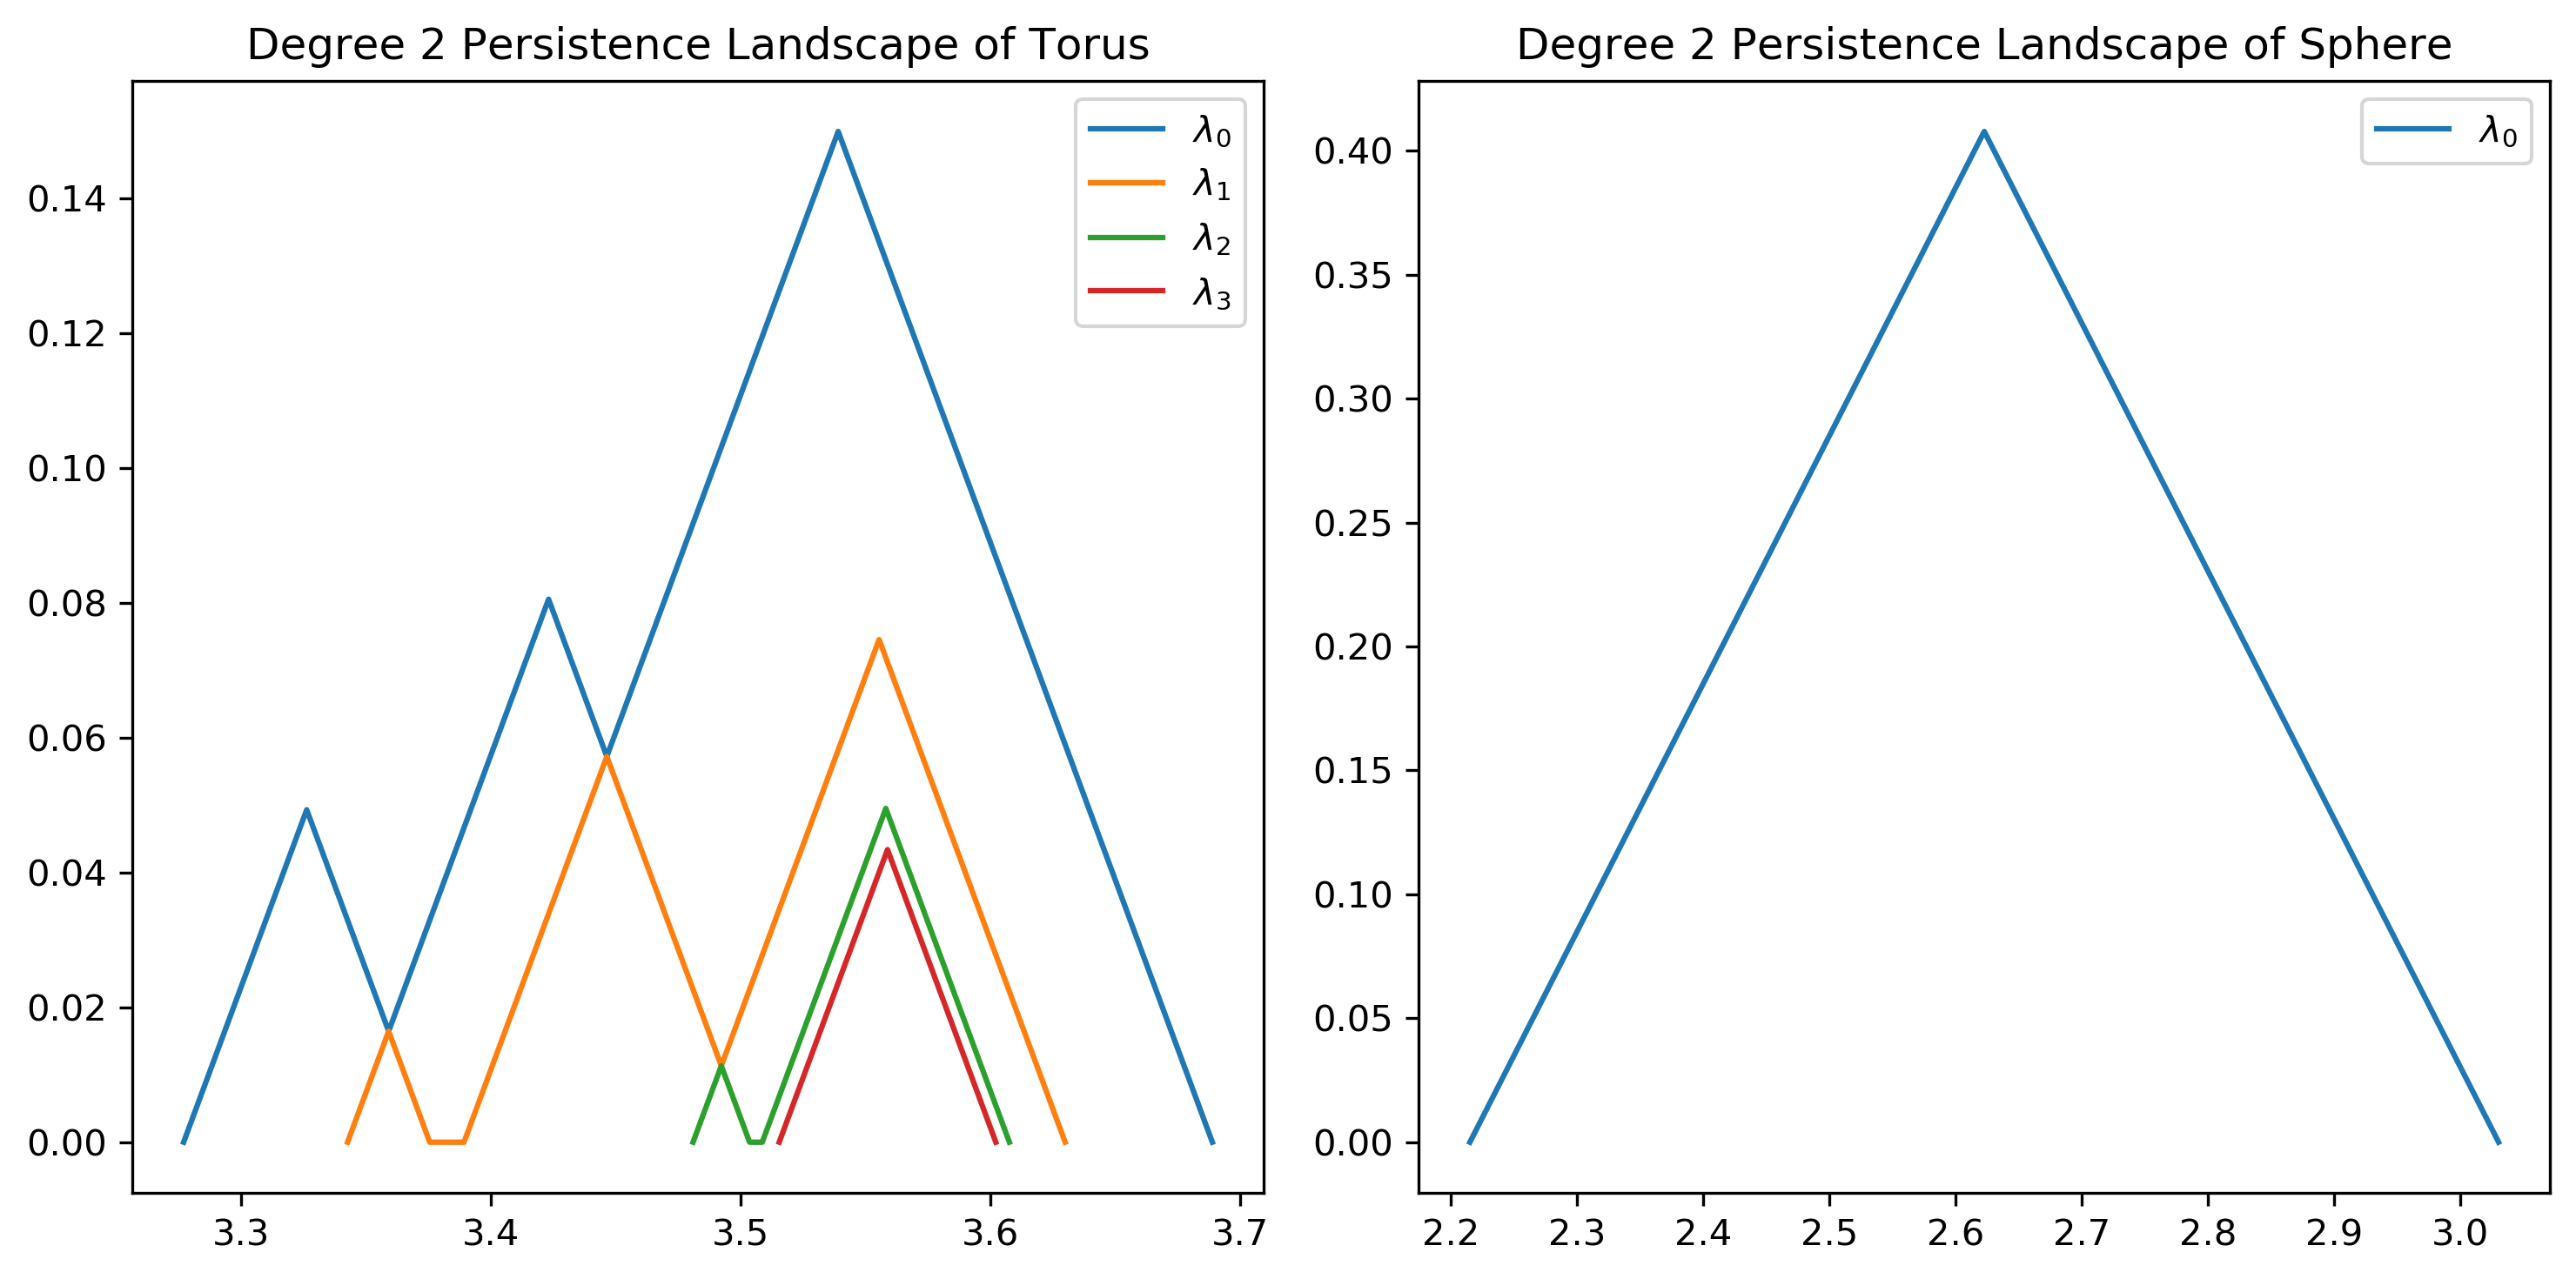

In [6]:
# plot landscapes
fig, axs = plt.subplots(1, 2, dpi=300)
fig.set_size_inches(10, 5)

persim.plot_landscape_simple(persim.PersLandscapeExact(dgms_torus, hom_deg=2),
                             title="Degree 2 Persistence Landscape of Torus", ax=axs[0])

persim.plot_landscape_simple(persim.PersLandscapeExact(dgms_sphere, hom_deg=2),
                            title="Degree 2 Persistence Landscape of Sphere", ax=axs[1])

fig.tight_layout()

## Section 2: PCA and Classification

In this section, we construct a list of landscapes in degree 2, project down onto the first two principal components, and use linear support vector classification to determine which landscapes came from the torus and which came from the sphere.

In [7]:
landscapes_torus = []
landscapes_sphere = []

for i in range(100):
    estimator_torus = persim.PLE(hom_deg=1)
    
    dgm_torus = rips.fit_transform(data_torus)
    
    crit_pts_torus = estimator_torus.fit_transform(dgm_torus)
    
    landscapes_torus.append(crit_pts_torus)
    
    
    estimator_sphere = persim.PLE(hom_deg=1)
    
    dgm_sphere = rips.fit_transform(data_sphere)
    
    crit_pts_sphere = estimator_sphere.fit_transform(dgm_sphere)
    
    landscapes_sphere.append(crit_pts_sphere)

In [8]:
print(np.shape(landscapes_torus))
print(np.shape(landscapes_sphere))

(100, 8)
(100, 8)


In [67]:
"""
def vectorize(crit_pts):
    array = np.array([np.hstack(crit_pts[i]) for i in range(len(crit_pts))])
    return np.hstack(array)
 
def to_matrix(landscape_list):
    vectors = []
    for cp in landscape_list:
        vectors.append(vectorize(cp))

    maxlen = np.max([len(v) for v in vectors])

    pad = []
    for v in vectors:
        pad.append(np.pad(v, maxlen - len(v)))

    return np.array(pad)
"""

'\ndef vectorize(crit_pts):\n    array = np.array([np.hstack(crit_pts[i]) for i in range(len(crit_pts))])\n    return np.hstack(array)\n \ndef to_matrix(landscape_list):\n    vectors = []\n    for cp in landscape_list:\n        vectors.append(vectorize(cp))\n\n    maxlen = np.max([len(v) for v in vectors])\n\n    pad = []\n    for v in vectors:\n        pad.append(np.pad(v, maxlen - len(v)))\n\n    return np.array(pad)\n'

In [54]:
# Reshape data
ls_torus = to_matrix(landscapes_torus)
ls_sphere = to_matrix(landscapes_sphere)


In [64]:
pca_t = PCA(n_components=2)

pca_t.fit(ls_torus)

pca_torus = pca_t.transform(ls_torus)

pca_s = PCA(n_components=2)

pca_s.fit(ls_sphere)

pca_sphere = pca_s.transform(ls_sphere)

/home/calder/Malgus/.local/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/calder/Malgus/.local/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


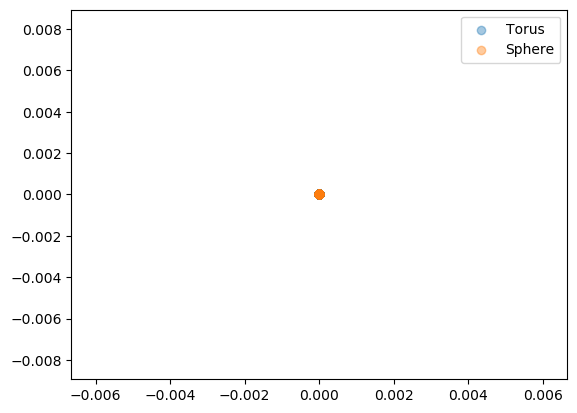

In [65]:
plt.figure()
plt.scatter(pca_torus[:,0], pca_torus[:,1], label='Torus', alpha=0.4)
plt.scatter(pca_sphere[:,0], pca_sphere[:,1], label='Sphere', alpha=0.4)
plt.legend()

In [66]:
print(pca_torus)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
